In [20]:
%matplotlib notebook
import glob
import pandas as pd
import mne
import matplotlib.pyplot as plt
from io import StringIO
import mne
from mne.io import read_raw_eeglab, read_epochs_eeglab
import numpy as np
from scipy import signal
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm_notebook
from sklearn.svm import SVR
from sklearn import preprocessing

import autosklearn.regression
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import multiprocessing
from oct2py import octave

from joblib import Parallel, delayed
import multiprocessing
from joblib import wrap_non_picklable_objects
import json
import pickle
import os.path
from mpl_toolkits.mplot3d import axes3d
from math import e

from math import exp
from math import log

In [21]:
features_filename = '55-features-v1.xlsx'

In [22]:
df = pd.read_excel(features_filename, index_col=0)

In [23]:
p1 = np.percentile(df['mep_category_cmap'], 50)
cat = np.ones(len(df['mep_category_cmap'])) * (df['mep_category_cmap'] > p1)
df['mep_category_cmap_across_subjects'] = cat

# Histogram

In [24]:
mep_metric = 'mep_category_cmap_across_subjects'
channel = 'ltm1'

In [25]:
def frange(start, stop, numelements):
    """range function for floats"""
    incr = (stop - start) / numelements
    return (start + x * incr for x in range(numelements))

def exprange(values, numelements):
    """exponential range - each element is a fixed factor bigger than the previous"""
    start = values.min()
    stop = values.max()
    r = (exp(x) for x in frange(log(start), log(stop * 2), numelements))
    arr = []
    for x in r:
        arr.append(x)
    arr.append(np.maximum(stop, arr[-1]) + (stop-start) * 0.2)
    return np.array(arr)

In [26]:
def plot_power_hist(df, band_name, channel):
    df2 = df
    df2['wavelet_'+channel+'_' + band_name + '_max_power_freq_bin'] = pd.cut(df2['wavelet_'+channel+'_' + band_name + '_max_power_freq'], exprange(df2['wavelet_'+channel+'_' + band_name + '_max_power_freq'], 5))
    df2['wavelet_'+channel+'_' + band_name + '_max_power_freq_bin_left'] = df2['wavelet_'+channel+'_' + band_name + '_max_power_freq_bin'].apply(lambda x: x.left)

    df_small = df2[df2[mep_metric] == 0]
    df_small = df_small.groupby('wavelet_'+channel+'_' + band_name + '_max_power_freq_bin_left').count()

    df_large = df2[df2[mep_metric] == 1]
    df_large = df_large.groupby('wavelet_'+channel+'_' + band_name + '_max_power_freq_bin_left').count()

    ind = np.arange(df_small.shape[0])
    width = 0.35
    fig, ax = plt.subplots(figsize=(9,4))
    ax.bar(ind * 1.0, df_small['all_alpha_max_power'], width, label='Small')
    ax.bar(ind * 1.0 + width, df_large['all_alpha_max_power'], width, label='Small')
    ax.set_xticks(ind * 1.0)
    ax.set_xticklabels(df_small.index, fontdict={'fontsize':7})
    ax.set_xlabel('Power')
    ax.set_ylabel('MEP count')
    ax.set_title('Frequency: ' + band_name + ' - ' + channel)    

<IPython.core.display.Javascript object>


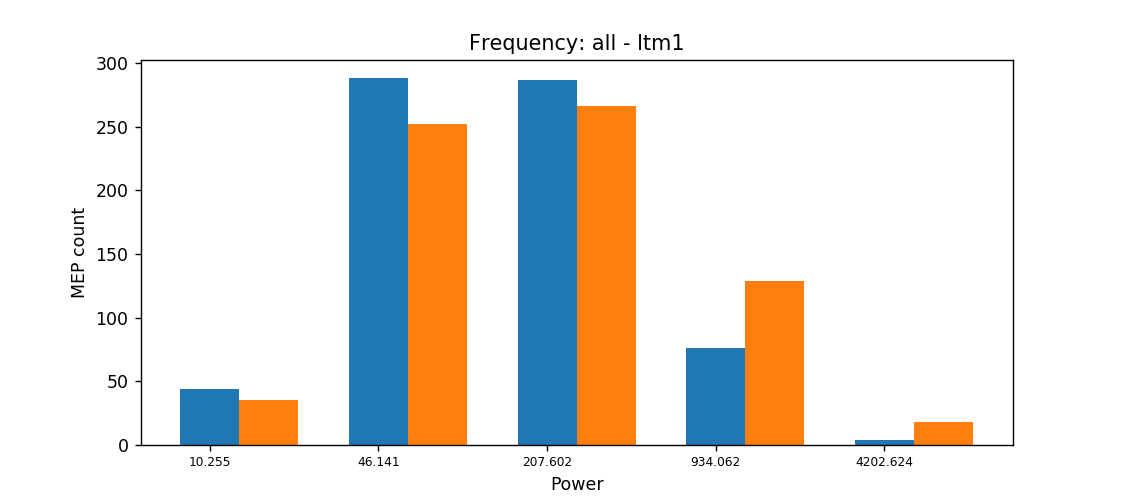

<IPython.core.display.Javascript object>


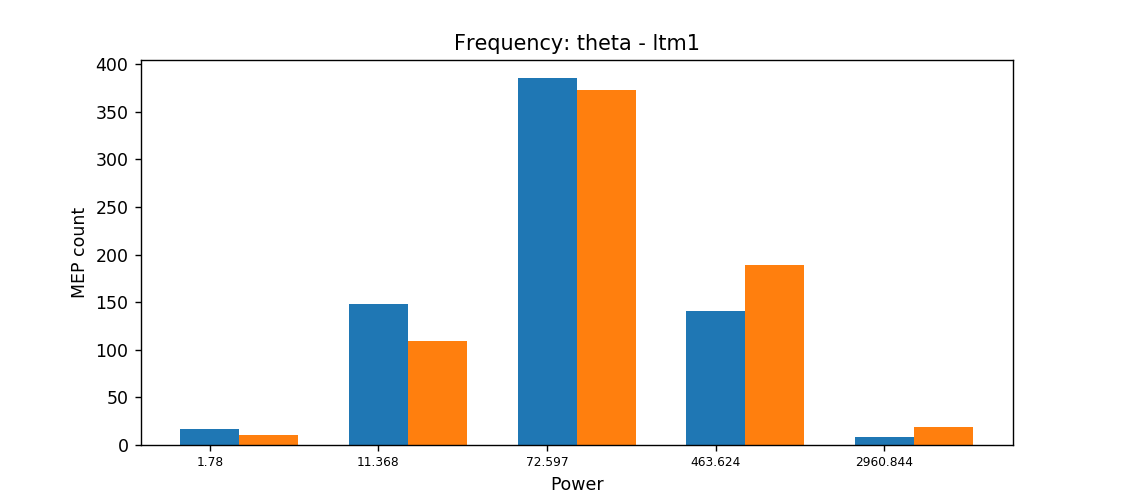

<IPython.core.display.Javascript object>


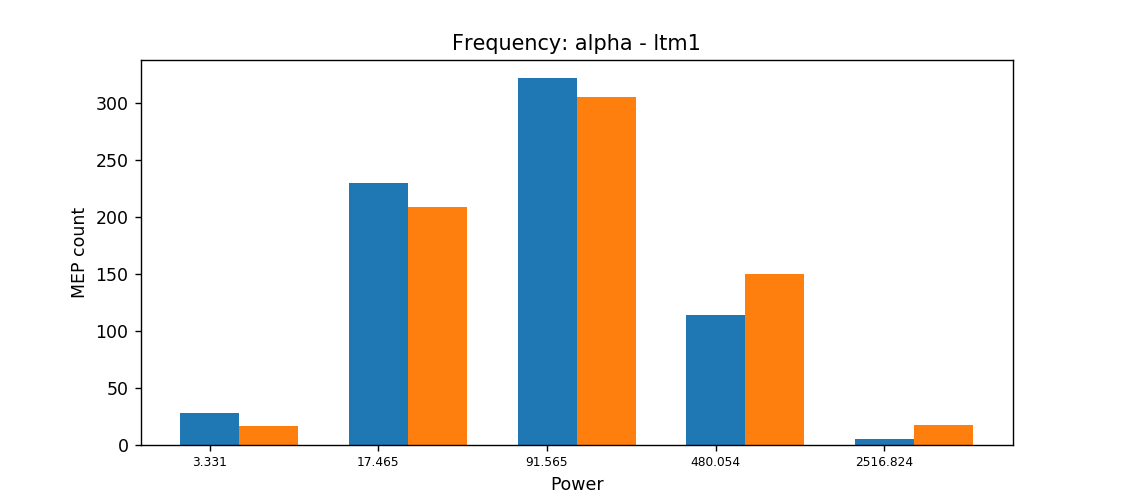

<IPython.core.display.Javascript object>


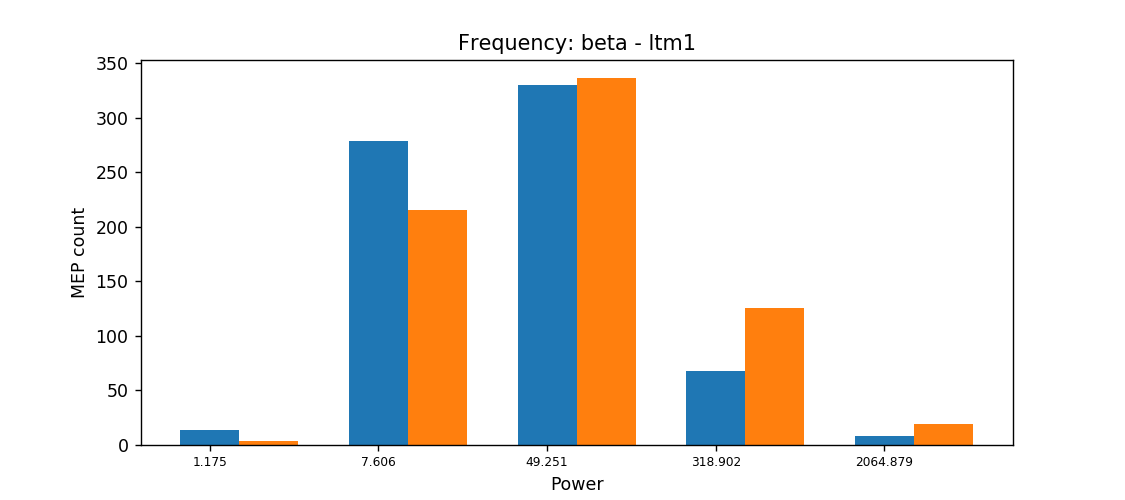

<IPython.core.display.Javascript object>


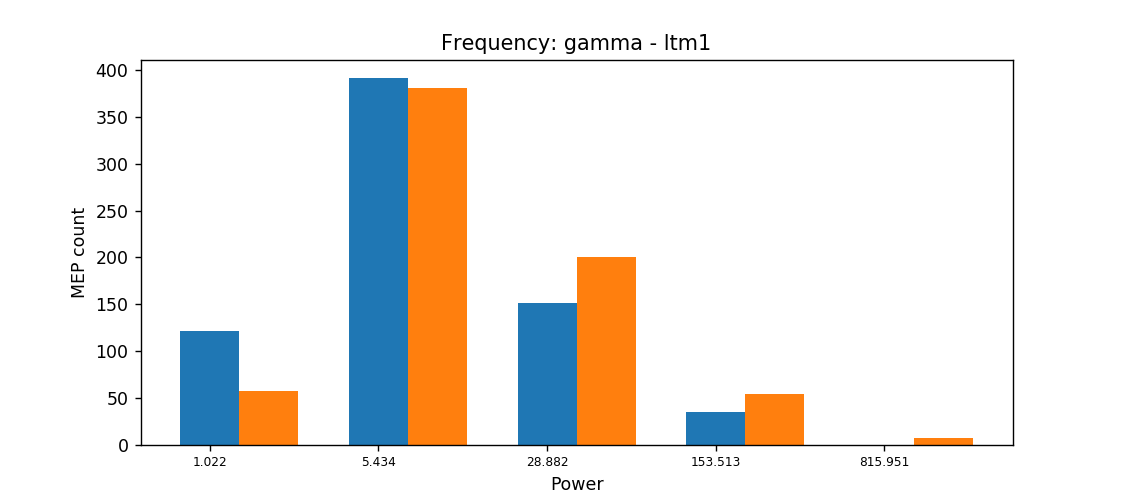

In [27]:
plot_power_hist(df, 'all', 'ltm1')
plot_power_hist(df, 'theta', 'ltm1')
plot_power_hist(df, 'alpha', 'ltm1')
plot_power_hist(df, 'beta', 'ltm1')
plot_power_hist(df, 'gamma', 'ltm1')

<IPython.core.display.Javascript object>


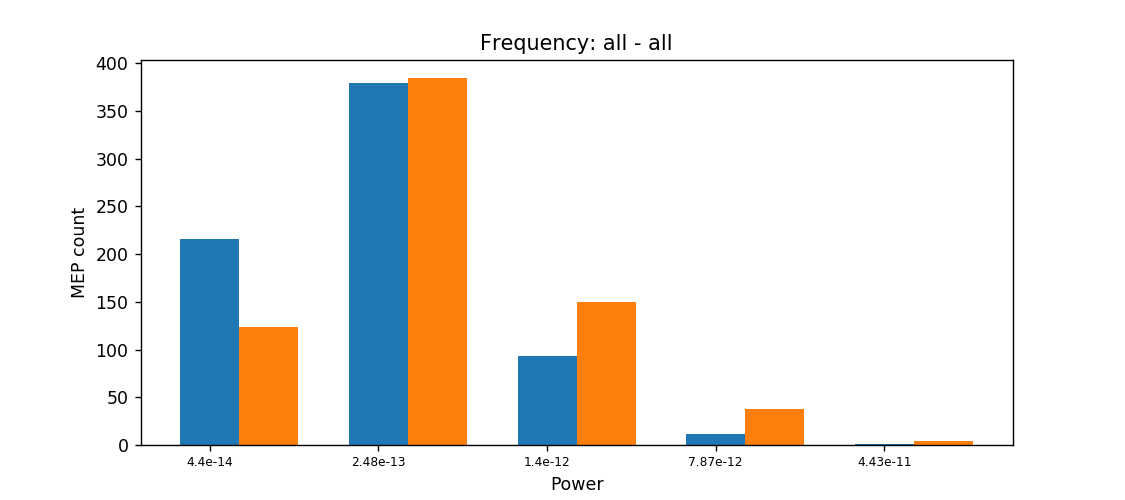

<IPython.core.display.Javascript object>


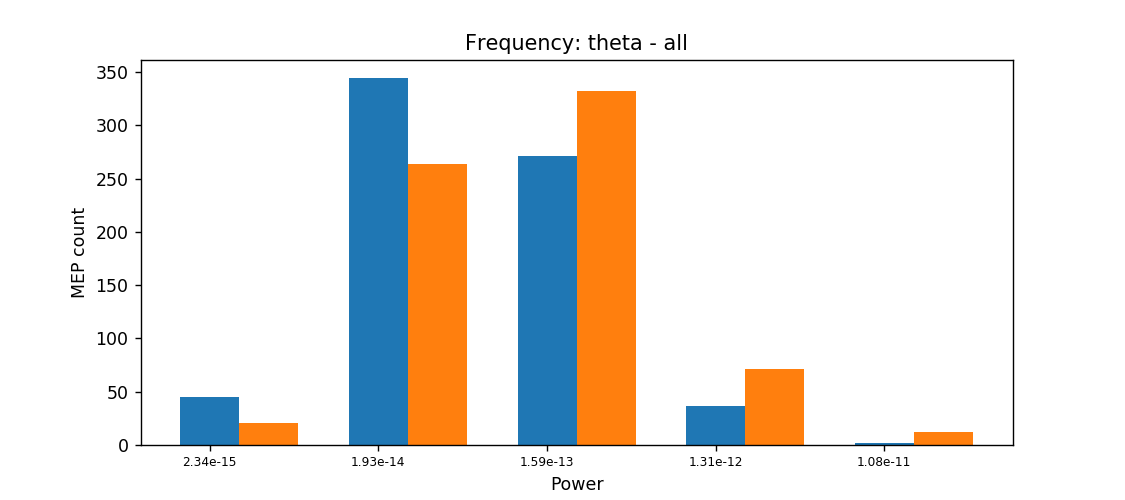

<IPython.core.display.Javascript object>


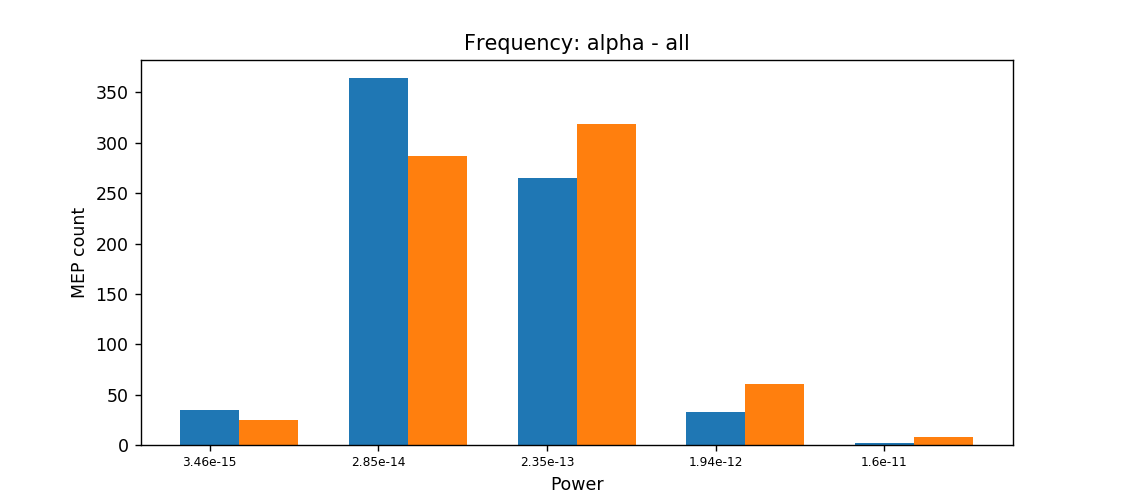

<IPython.core.display.Javascript object>


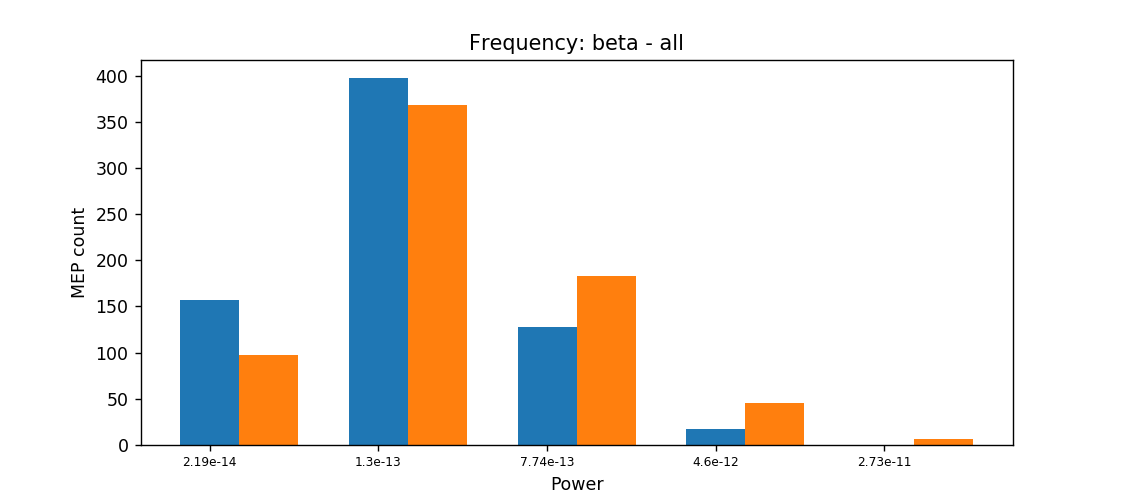

<IPython.core.display.Javascript object>


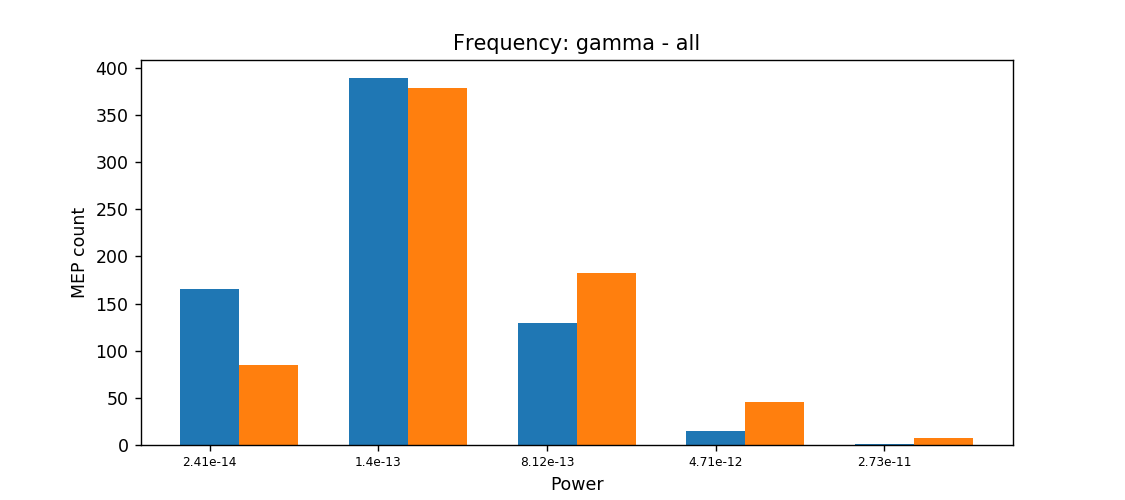

In [28]:
plot_power_hist(df, 'all', 'all')
plot_power_hist(df, 'theta', 'all')
plot_power_hist(df, 'alpha', 'all')
plot_power_hist(df, 'beta', 'all')
plot_power_hist(df, 'gamma', 'all')

# Plot mean power in each band

In [29]:
all_interval = pd.Interval(6, 80, 'both')
delta_interval = pd.Interval(0.3, 3.5, 'left')
theta_interval = pd.Interval(3.5, 8, 'neither')
alpha_interval = pd.Interval(8, 13, 'both')
beta_interval = pd.Interval(13, 30, 'right')
gamma_interval = pd.Interval(30, 80, 'both')

In [30]:
df2 = df

<IPython.core.display.Javascript object>


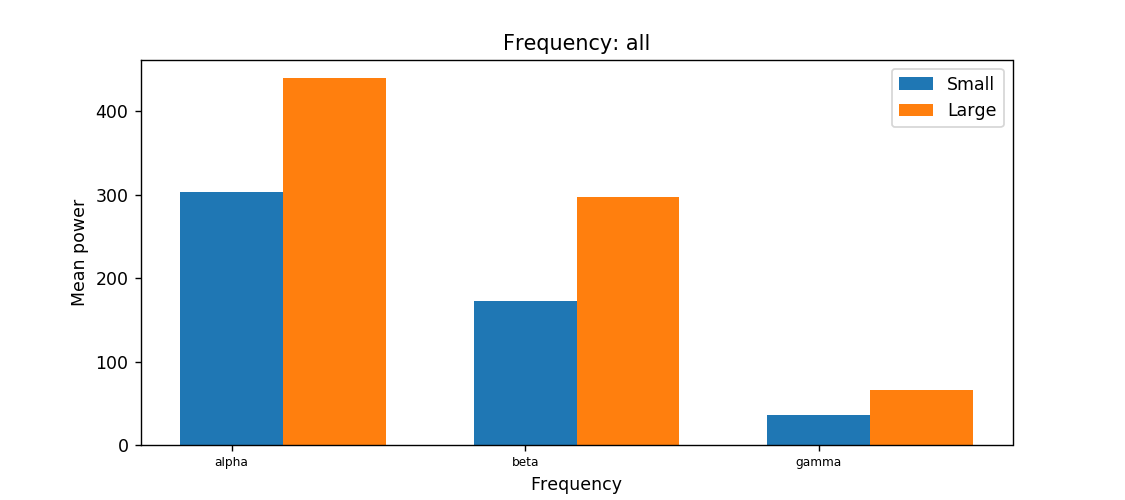

In [36]:
def mean_power_in_band(df, band, channel):
    df_small = df2[df2[mep_metric] == 0]
    small_mean_power = df_small['wavelet_' + channel + '_' + band + '_max_power_freq'].mean()

    df_large = df2[df2[mep_metric] == 1]
    large_mean_power = df_large['wavelet_' + channel + '_' + band + '_max_power_freq'].mean()
    return small_mean_power, large_mean_power

chanel = 'ltm1'
ind = np.arange(3)
width = 0.35
fig, ax = plt.subplots(figsize=(9,4))
ax.bar(ind, [mean_power_in_band(df, 'alpha', 'ltm1')[0], mean_power_in_band(df, 'beta', 'ltm1')[0], mean_power_in_band(df, 'gamma', 'ltm1')[0]], width, label='Small')
ax.bar(ind + width, [mean_power_in_band(df, 'alpha', 'ltm1')[1], mean_power_in_band(df, 'beta', 'ltm1')[1], mean_power_in_band(df, 'gamma', 'ltm1')[1]], width, label='Large')
ax.set_xticks(ind * 1.0)
ax.set_xticklabels(['alpha', 'beta', 'gamma'], fontdict={'fontsize':7})
ax.set_xlabel('Frequency')
ax.set_ylabel('Mean power')
ax.set_title('Frequency: ' + channel)
ax.legend()

<IPython.core.display.Javascript object>


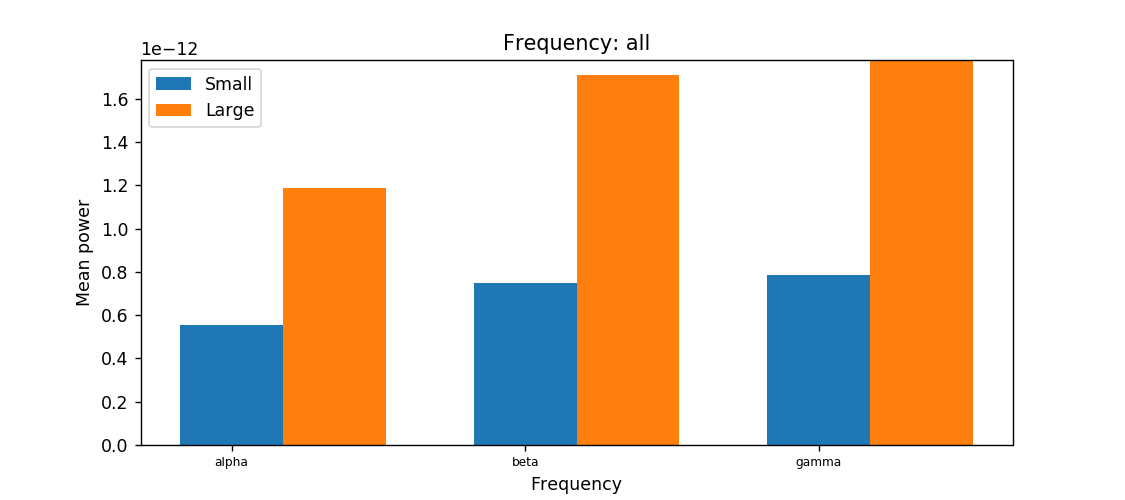

In [38]:
channel = 'all'
ind = np.arange(3)
width = 0.35
fig, ax = plt.subplots(figsize=(9,4))
ax.bar(ind, [mean_power_in_band(df, 'alpha', channel)[0], mean_power_in_band(df, 'beta', channel)[0], mean_power_in_band(df, 'gamma', channel)[0]], width, label='Small')
ax.bar(ind + width, [mean_power_in_band(df, 'alpha', channel)[1], mean_power_in_band(df, 'beta', channel)[1], mean_power_in_band(df, 'gamma', channel)[1]], width, label='Large')
ax.set_xticks(ind * 1.0)
ax.set_xticklabels(['alpha', 'beta', 'gamma'], fontdict={'fontsize':7})
ax.set_xlabel('Frequency')
ax.set_ylabel('Mean power')
ax.set_title('Frequency: ' + channel)
ax.legend()

<IPython.core.display.Javascript object>


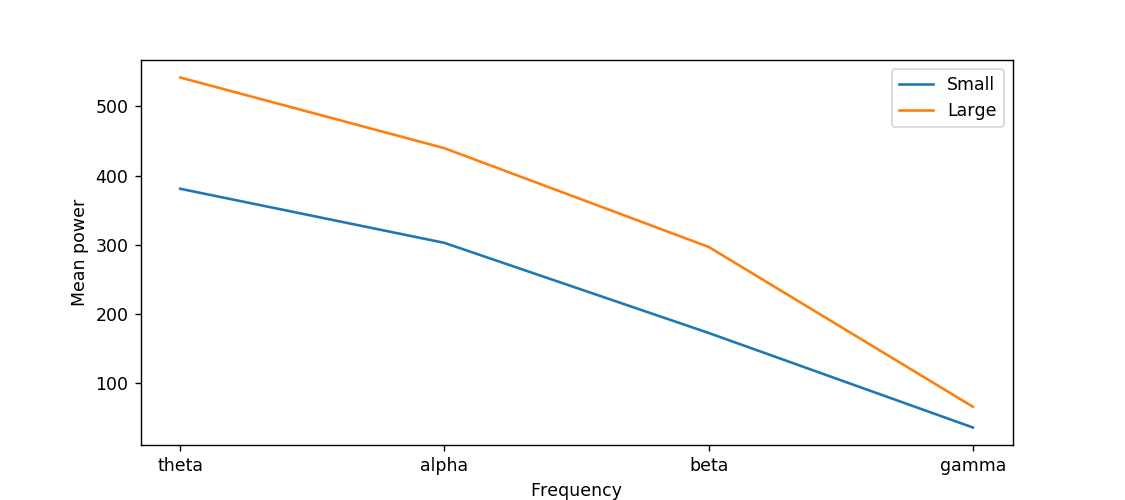

In [40]:
channel = 'ltm1'
plt.figure(figsize=(9,4))
plt.plot(['theta', 'alpha', 'beta', 'gamma'], [mean_power_in_band(df, 'theta', channel)[0], mean_power_in_band(df, 'alpha', channel)[0], mean_power_in_band(df, 'beta', channel)[0], mean_power_in_band(df, 'gamma', channel)[0]], label='Small')
plt.plot(['theta', 'alpha', 'beta', 'gamma'], [mean_power_in_band(df, 'theta', channel)[1], mean_power_in_band(df, 'alpha', channel)[1], mean_power_in_band(df, 'beta', channel)[1], mean_power_in_band(df, 'gamma', channel)[1]], label='Large')
plt.xlabel('Frequency')
plt.ylabel('Mean power')
plt.legend()

<IPython.core.display.Javascript object>


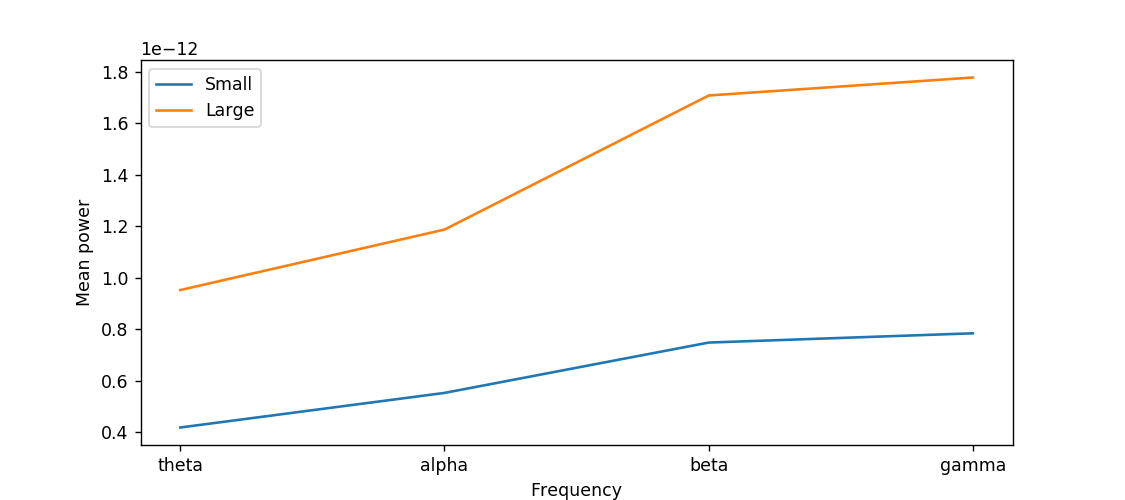

In [41]:
channel = 'all'
plt.figure(figsize=(9,4))
plt.plot(['theta', 'alpha', 'beta', 'gamma'], [mean_power_in_band(df, 'theta', channel)[0], mean_power_in_band(df, 'alpha', channel)[0], mean_power_in_band(df, 'beta', channel)[0], mean_power_in_band(df, 'gamma', channel)[0]], label='Small')
plt.plot(['theta', 'alpha', 'beta', 'gamma'], [mean_power_in_band(df, 'theta', channel)[1], mean_power_in_band(df, 'alpha', channel)[1], mean_power_in_band(df, 'beta', channel)[1], mean_power_in_band(df, 'gamma', channel)[1]], label='Large')
plt.xlabel('Frequency')
plt.ylabel('Mean power')
plt.legend()

# Plot max power count (among all bands) in each band across

In [33]:
df2=df

In [34]:
def filter_interval(df2, column, interval):
    arr = []
    df3 = df2[df2[mep_metric] == 0]
    for el in df3[column]:
        arr.append(el in interval)
    df_small = df3[arr]        
    
    arr = []
    df4 = df2[df2[mep_metric] == 1]
    for el in df4[column]:
        arr.append(el in interval)
    df_large = df4[arr]    
        
    return df_small, df_large

<IPython.core.display.Javascript object>


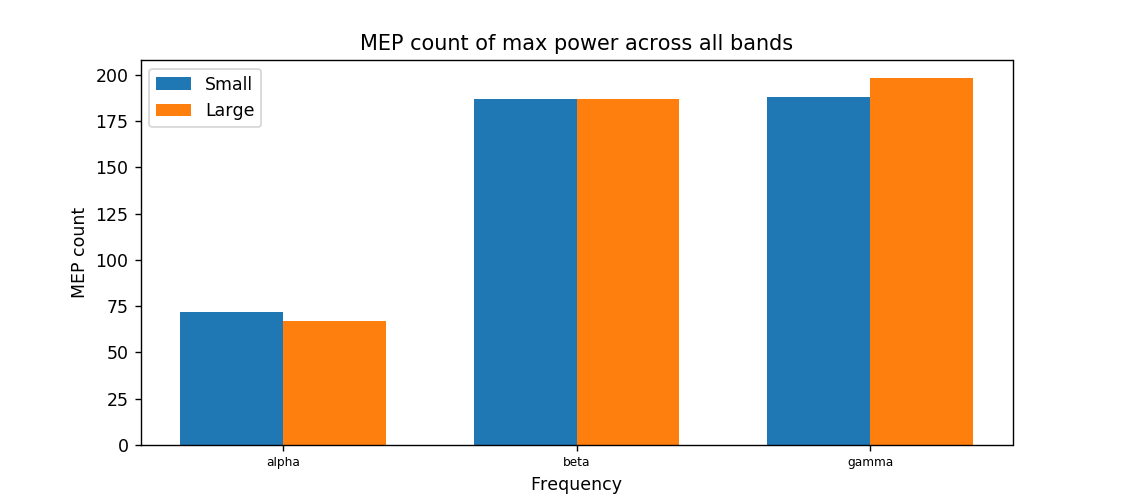

In [35]:
channel = 'all'

ind = np.arange(3)
width = 0.35
fig, ax = plt.subplots(figsize=(9,4))

df_list_1 = filter_interval(df, 'wavelet_' + channel + '_all_max_power_at_freq', alpha_interval)
df_list_2 = filter_interval(df, 'wavelet_' + channel + '_all_max_power_at_freq', beta_interval)
df_list_3 = filter_interval(df, 'wavelet_' + channel + '_all_max_power_at_freq', gamma_interval)

ax.bar(ind, [df_list_1[0].shape[0], df_list_2[0].shape[0], df_list_3[0].shape[0]], width, label='Small')
ax.bar(ind + width, [df_list_1[1].shape[0], df_list_2[1].shape[0], df_list_3[1].shape[0]], width, label='Large')

ax.set_xticks(ind + width/2)
ax.set_xticklabels(['alpha', 'beta', 'gamma'], fontdict={'fontsize':7})
ax.set_xlabel('Frequency')
ax.set_ylabel('MEP count')
ax.set_title('MEP count of max power across all bands')
ax.legend()